In [1]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['font.size'] = 28.0
import matplotlib.pyplot as plt
import numpy as np
import loadMWSnap as mws
import velocitySpectroscopyHelpers as vsh
reload(mws);
reload(vsh);

In [2]:
reload(mws);
# Load the particle data
# pos in physical kpc, vel in km/s, mass in physical m_sun
rawpos, rawvel, partmass, ldim, data = mws.loadMWSnap(halo=374)

Reading rockstar output /nfs/slac/g/ki/ki21/cosmo/yymao/mw_resims/halos/Halo374/rockstar/hlists/hlist_1.00000.list
Reading MUSIC log /nfs/slac/g/ki/ki21/cosmo/yymao/mw_resims/halos/Halo374/music.conf_log.txt
Lagrangian patch dimensions are (486, 224, 242)
Reading Gadget snapshot /nfs/slac/g/ki/ki21/cosmo/yymao/mw_resims/halos/Halo374/output/snapshot_235


In [3]:
reload(vsh);
### Rotate the halo around the center aribitrarily ###
# np.random.seed(10291989)
# rot = vsh.generateRotationMatrix()

### Rotate the halo so that its principal axes align with the coordinates ###
rfilt = np.sum(rawpos**2, axis=1) < vsh.r_sun**2 # use only particles inside the Sun's orbit for this
cov = np.cov(rawpos[rfilt].T)
vals, vecs = np.linalg.eig(cov)
rot = vecs

# Add an additional rotation component
angle = 0.0
# angle = 0.25*np.pi
ax = 1
sa = np.sin(angle)
ca = np.cos(angle)
rmat = np.roll(np.roll(np.array([[ca, -sa, 0], [sa, ca, 0], [0, 0, 1]]), ax, axis=0), ax, axis=1)
rot = np.dot(rot, rmat)

# shift everything relative to the sun's location and velocity
pos = np.dot(rawpos, rot) - vsh.pos_sun
vel = np.dot(rawvel, rot) - vsh.vel_sun
# pos = rawpos - vsh.pos_sun
# vel = rawvel - vsh.vel_sun

In [4]:
### Micro-X parameters ###
fwhm_MX = 3.0/(3.5*10**3) # fractional energy resolution at 3.5 keV
theta_MX = 20.0
micro_x_params = {
    'aperture': 1.0, # effective aperture in cm^2
    'exposure': 300.0, # exposure time in sec
    'fov': 2*np.pi*(1.-np.cos(theta_MX*np.pi/180.)), # solid angle of the FOV in str
    'sigma_energy': fwhm_MX/(2.*(2.*np.log(2.))**0.5), # Guassian sigma of the energy response
    'theta_sample': theta_MX, # angular radius of the sampling cone in degrees
}
print micro_x_params
micro_x_result = vsh.spectroscopy(pos, vel, partmass, **micro_x_params)
# print micro_x_result



{'aperture': 1.0, 'fov': 0.37892243899248773, 'sigma_energy': 0.00036399505726629385, 'theta_sample': 20.0, 'exposure': 300.0}
. . . . . . . . . 


In [5]:
# Ranjan's analysis
# \ell = b = 25 degree. 438.62 Exp[-(1/2) (En1 - 3.50083)^2/(0.00134421)^2].  
# The central value is 3.50083, and the width is 66.2925/(3 10^5).
# \ell = 65 degree and b = 25 degree.  230.79 Exp[-(1/2) (En1 - 3.502)^2/(0.0013551)^2].  
# The central value is 3.502, and the width is 100.621/(3 10^5).
ranjan_result = {'l': np.array([-65., -25., 25., 65.]), 'centroid': np.array([0.002, 0.00083, -0.00083, -0.002])/3.5,
                'sigma_centroid': np.array([100.621, 66.2925, 66.2925, 100.621])/3.0e5}

In [13]:
# Devon's analysis on Micro-X
# NOTE: Assumes 3.5 keV for now!!!
reload(vsh);

devon_result = vsh.spectroscopy_analytic(**micro_x_params)
# print micro_x_result

# for i in xrange(9):
#     print 'l =', devon_result['l'][i], 'counts =', devon_result['counts'][i]


. . . . . . . . . 


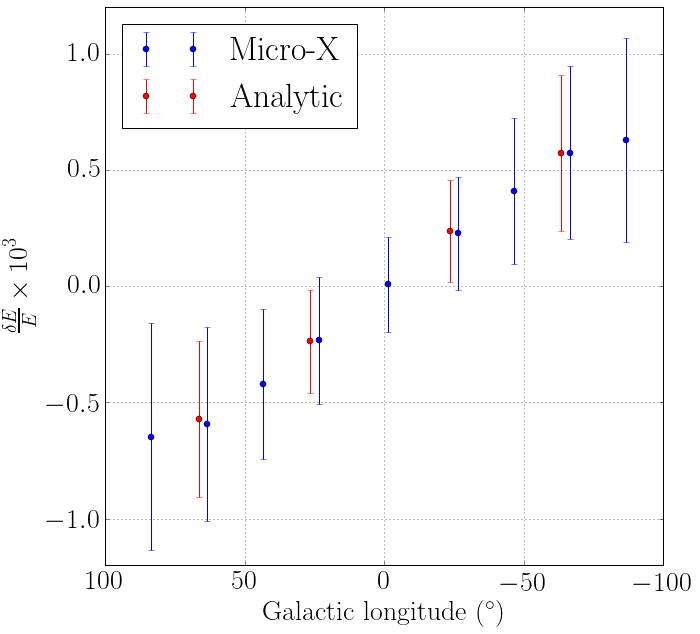

In [16]:
# Plot it up!
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# 
ax.errorbar(micro_x_result['l']-1.5, micro_x_result['centroid']*10**3,\
            yerr=micro_x_result['sigma_centroid']*10**3, fmt='o', c='blue', label='Micro-X')

ax.errorbar(ranjan_result['l']+1.5, ranjan_result['centroid']*10**3,\
            yerr=ranjan_result['sigma_centroid']*10**3, fmt='o', c='red', label='Analytic')

# ax.errorbar(devon_result['l']-4.5, devon_result['centroid']*10**3,\
#             yerr=devon_result['sigma_centroid']*10**3, fmt='o', c='black', label='Devon')

# frills
# ax.set_title(r'Decay line spectral shift')
ax.set_ylabel(r'$\frac{\delta E}{E} \times 10^3$')
ax.set_xlabel(r'Galactic longitude ($^{\circ}$)')
ax.set_xlim(-100., 100.)
ax.invert_xaxis()
ax.set_ylim(-1.2, 1.2)
ax.grid(True)

ax.legend(loc='upper left')

fig.savefig('../img/de_vs_l.png', bbox_inches='tight')

In [ ]:

### Astro-H parameters ###
# fov_AH = 9.0 # field of view in arcmin^2
# fov_AH *= 8.461594994075239e-8 # convert to str
# astro_h_params = {'aperture': 200.0, 'exposure': 2.0e6, 'fov': fov_AH, \
#     'sigma_energy': 1.7/(3.5*10**3), 'theta_sample': 2.0}
# print astro_h_params
# astro_h_result = vsh.spectroscopy(pos, vel, partmass, **astro_h_params)
# print astro_h_result

In [ ]:
# Plot the halo looking down the LOS from the Sun to check symmetry
fsz = 6
fig, axes = plt.subplots(1, 3, figsize=(3*fsz, fsz))

sfilt = (np.abs(pos[:,0]+vsh.r_sun) < 2*vsh.r_sun)*(np.abs(pos[:,1]) < 2*vsh.r_sun)*(np.abs(pos[:,2]) < 2*vsh.r_sun)
fpos = pos[sfilt]+vsh.pos_sun

# looking down the x-axis towards the GC
partargs = {'s': 0.4, 'c': 'black', 'lw': 0}
sunargs = {'s': 100.0, 'c': 'yellow', 'lw': 0}
axes[0].scatter(fpos[:,1], fpos[:,2], **partargs)
axes[0].scatter(vsh.pos_sun[1], vsh.pos_sun[2], **sunargs)
axes[1].scatter(fpos[:,0], fpos[:,1], **partargs)
axes[1].scatter(vsh.pos_sun[0], vsh.pos_sun[1], **sunargs)
axes[2].scatter(fpos[:,0], fpos[:,2], **partargs)
axes[2].scatter(vsh.pos_sun[0], vsh.pos_sun[2], **sunargs)
for ax in axes:
    ax.set_xlim([-2*vsh.r_sun, 2*vsh.r_sun])
    ax.set_ylim([-2*vsh.r_sun, 2*vsh.r_sun])
    ax.grid(True)
    
fig.suptitle(r'MW halo viewed from the Sun')
# ax.set_xlabel(r'$x$ [kpc]')
# ax.set_ylabel(r'$y$ [kpc]')

In [ ]:
'''
An example plot to show how sampling is done

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
zoom = 800 # kpc
ax.set_xlim([-0.5*zoom, 0.5*zoom])
ax.set_ylim([-0.5*zoom, 0.5*zoom])
ax.set_title(r'MW halo: Sampling the FOV')
ax.set_xlabel(r'$x$ [kpc]')
ax.set_ylabel(r'$y$ [kpc]')
cpos, _, _ = vsh.sample_los(pos, vel, beam_radius=20.0)
sfilt = np.abs(pos[:,2]) < 1.0 # filter all particles into a thin 1 kpc slab to make plotting easier
ax.scatter(pos[sfilt][:,0], pos[sfilt][:,1], s=0.5, c='black', lw=0)
ax.scatter(cpos[:,0], cpos[:,1], s=2.0, c='red', lw=0)
'''

In [ ]:
'''
Code to test uniformity of 3d rotation sampling.
Looks good!

from mpl_toolkits.mplot3d import Axes3D
fig = matplotlib.pyplot.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection = '3d')

whisk = np.array([[-0.02, 0.0, 1.0], [0.02, 0.0, 1.0]])

for i in xrange(5000):
    rot = vsh.generateRotationMatrix()
    w = np.dot(whisk, rot)
    ax.plot(w[:,0], w[:,1], w[:,2], color = 'b');

ax.set_xlim([-1.1, 1.1]);
ax.set_ylim([-1.1, 1.1]);
ax.set_zlim([-1.1, 1.1]);
'''